In [1]:
import pandas as pd 
import numpy as np
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import re

In [2]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
import sys
sys.path.append('../evaluation/')

In [4]:
from utils_eval import build_pdb_dict

In [5]:
# root_path = 'pharmacophore_specific_eval/1ywn'  # 0 0 
# root_path = 'pharmacophore_specific_eval/4ara' # 0.48 0.49
# root_path = 'pharmacophore_specific_eval/1lhn'  # 0.08 0.08
# root_path = 'pharmacophore_specific_eval/4b84'  # 0.57 0.70
# root_path = 'pharmacophore_specific_eval/5ni6'  # 0.07 0.08
# root_path = 'pharmacophore_specific_eval/5idn'  # 0.23 0.25 
# root_path = 'pharmacophore_specific_eval/5ni2'  # 0.13 0.15
# root_path = 'pharmacophore_specific_eval/4ijw'  # 0.36 0.39
root_path = 'pharmacophore_specific_eval/3ey4'  # 0.49 0.45
# root_path = 'pharmacophore_specific_eval/3r58'  # 0.70 0.70
# root_path = 'pharmacophore_specific_eval/4k1l'  # 0.58 0.62

aromatic = True

In [6]:
# ligand_filename = '1ywn_A_rec_1ywn_lif_lig_tt_docked_0.sdf'
# ligand_filename = '4b81_B_rec_4ara_c56_lig_tt_min_0.sdf'
# ligand_filename = '1lhu_A_rec_1lhn_aon_lig_tt_min_0.sdf'
# ligand_filename = '4b84_A_rec_4b84_z5k_lig_tt_min_0.sdf'
# ligand_filename = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0.sdf'
# ligand_filename = '5hbh_A_rec_5idn_6a7_lig_tt_min_0.sdf'
# ligand_filename = '5aen_A_rec_5ni2_dj3_lig_tt_min_0.sdf'
# ligand_filename = '3d3e_B_rec_4ijw_1eq_lig_tt_min_0.sdf'
ligand_filename = '4yyz_B_rec_3ey4_352_lig_tt_docked_12.sdf'
# ligand_filename = '4h7c_A_rec_3r58_nps_lig_tt_min_0.sdf'
# ligand_filename = '3ey4_C_rec_4k1l_sff_lig_tt_min_0.sdf'

In [7]:
log_path = os.path.join(root_path, 'logs')
log_path = log_path+'_aromatic' if aromatic else log_path
gen_path = os.path.join(root_path, 'aromatic' if aromatic else 'base')

raw_data_path = '../../data/cleaned_crossdocked_data/raw'

log_files = os.listdir(log_path)
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [8]:
def test_ref_ligand(gen_lig, ori_lig, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    example = os.path.join(path, gen_lig+'.sdf')
    m = Chem.MolFromMolFile(example)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ori_lig]
    ref_file = os.path.join(raw_path, pdb_folder, ori_lig)
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [9]:
ba_df = pd.read_csv(os.path.join(root_path, 'binding_affinity_aromatic.csv' if aromatic else 'binding_affinity.csv'), header=0, index_col=0)
ba_df = ba_df.sort_values(by='Binding affinity')
ba_df.head(10)

,Binding affinity,CNN score,Reference
3ey4_199,-9.59,0.4650,-7.36235
3ey4_24,-9.37,0.3978,-7.36235
3ey4_6,-9.36,0.3958,-7.36235
3ey4_365,-9.33,0.4113,-7.36235
3ey4_128,-9.26,0.4474,-7.36235
3ey4_198,-9.21,0.3644,-7.36235
3ey4_111,-9.19,0.3707,-7.36235
3ey4_35,-9.08,0.3827,-7.36235
3ey4_443,-9.05,0.4150,-7.36235
3ey4_321,-9.03,0.3280,-7.36235


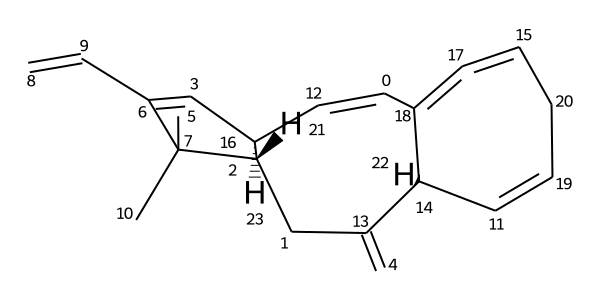

In [10]:
lig = '3ey4_199.sdf'
m, ref_m = test_ref_ligand(lig, ligand_filename) 
m

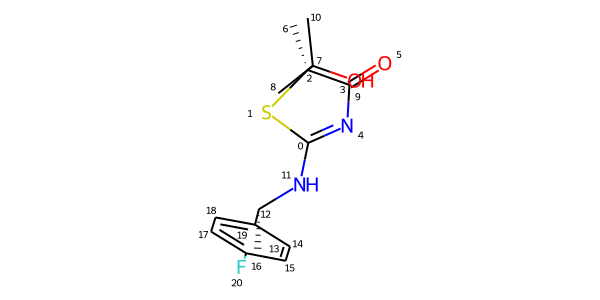

In [11]:
ref_m

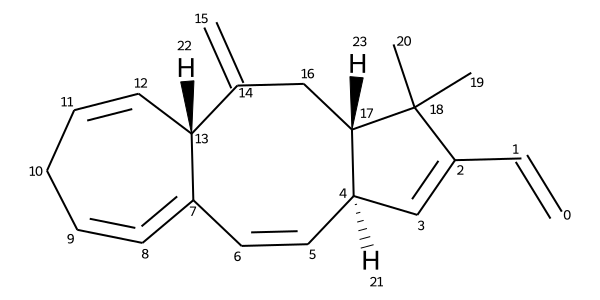

In [12]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

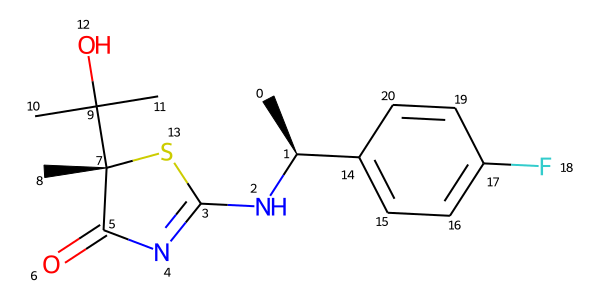

In [13]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [14]:
def viz(ligand, path=gen_path):
    example = os.path.join(path, ligand+'.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(example).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    
    return v

In [15]:
viz(lig)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
def compare(gen_lig, ori_lig, gen_path=gen_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ori_lig)
    pdb_folder = pdb_rev_dict[ori_lig]
    pr_pdb = match.group(1)
    print(pr_pdb)
    # protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ori_lig[ori_lig.rfind('rec')+4:ori_lig.rfind('lig')+3]
    # autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')
    autobox_ligand_file = os.path.join(root_path, ori_lig)

    ligand_file = os.path.join(gen_path, gen_lig+'.sdf')

    # out_folder = 'output_aromatic' if aromatic else 'output'
    # out_file = os.path.join(root_path, out_folder, gen_lig)
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    # v.rotate(90)
    # v.animate({'interval':1000})
    
    return v

In [28]:
compare(lig, ligand_filename)

4yyz_B_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
def viz_with_pr(gen_lig, ori_lig, root_path=root_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict, aromatic=True):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ori_lig)
    pdb_folder = pdb_rev_dict[ori_lig]
    pr_pdb = match.group(1)
    print(pr_pdb)
    protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ori_lig[ori_lig.rfind('rec')+4:ori_lig.rfind('lig')+3]

    autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')

    out_folder = 'output_aromatic' if aromatic else 'output'
    out_file = os.path.join(root_path, out_folder, gen_lig)
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(protein_file).read())
    v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModelsAsFrames(open(out_file).read())
    v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    v.zoomTo({'model':1})
    v.rotate(90)
    v.animate({'interval':1000})
    
    return v

In [17]:
viz_with_pr(lig, ligand_filename, aromatic=aromatic)

4yyz_B_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.